## Simplificar flujos de trabajos con pipelines

El concepto de los _pipelines_ es muy sencillo de entender: ajustar varios pasos de transformacion, uno seguido de otro, de tal manera que todos los pasos individuales se condencen en un solo paso global.

Pra esta parte trabajaremos con el archivo `Breast Cancer Wisconsin` del cual se puede obtener informacion desde la pagina web: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

df.columns = ['ID', 'Diagnosis']+ list(np.arange(1, 31))
df.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

In [ ]:
le.transform(['M', 'B'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [ ]:
# Usando pipelines para combinar procesos: escalamiento, PCA, modelado de datos
# =============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f'Test Accuracy: {np.round(pipe_lr.score(X_test, y_test), 4)}')

IMPORTANTE: La funcion `make_pipeline` puede tomar un numero arbitrario de transformadores de scikit learn (objetos que soportan `fit` y `transform` como entrada) seguido de un estimador de scikit learn que implemente los metodos `fit` y `predict`. El estimador siempre debe ir al final, y siempre debe existir.

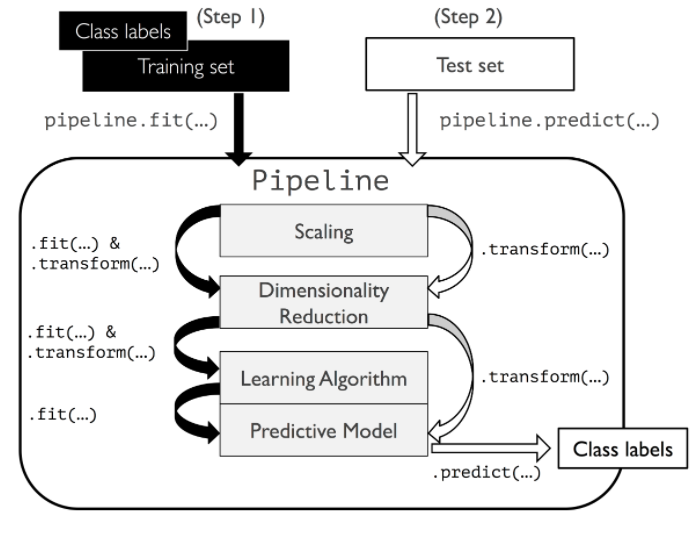

<div class="burk">
EJERCICIO</div><i class="fa fa-lightbulb-o "></i>

Utilice los datos anteriores junto con el pipeline generado para realizar la prediccion de los datos y evaluar el rendimiento de los conjuntos de entrenamiento y test.

In [ ]:
from sklearn.metrics import accuracy_score
y_pred_train = pipe_lr.predict(X_train)
print(f'Precision entrenamiento: {accuracy_score(y_train, y_pred_train)}')

In [ ]:
y_pred_test = pipe_lr.predict(X_test)
print(f'Precision prueba: {accuracy_score(y_test, y_pred_test)}')

## Utilizar validacion cruzada de K iteraciones paramejorar el rendimiento del modelo

El objetivo de esta tecnica es generar estimaciones fiables para la generalizacion del modelo a datos no vistos durante el entrenamiento, buscando evitar el subajuste y el sobreajuste.

En esta tecnica, se divide aleatoriamente el conjunto de datos de entrenamiento en k iteraciones sin reemplazo, donde k-1 iteraciones se utilizan para el entrenamiento del modelo y una iteracion para la evaluacion del rendimiento. Este proceso se repite k veces para obtener k modelos y estimaciones del rendimiento. 

Despues calculamos el rendimiento medio de los modelos basado en distintas e independientes iteraciones para obtener una estimacion del rendimiento que es menos sensible a la subdivision de datos. Esta tecnica se usa generalmente para la seleccion de modelos, es decir. la eleccion optima de los hiperparametros para el modelo.

Una vez se han encontrado los valores optimos de los hiperparametros, se puede volver a entrenar el modelo en el conjunto de entrenamiento completo y obtener una estimacion del rendimiento final mediante el conjunto de prueba independiente. Lo anterior se basa en el hecho de que proporcionar mas datos de entrenamiento a un modelo lo vuelva mas robusto y preciso.

El siguiente ejemplo se basa en una estimacion con k=10. El conjunto de entrenamiento esta dividido en 10 iteraciones, 9 para entrenar y 1 para evaluar el rendimiento. Ademas los rendimientos $E_i$ para cada iteracion se utilizan para calcular el rendimiento estimado medio del modelo:

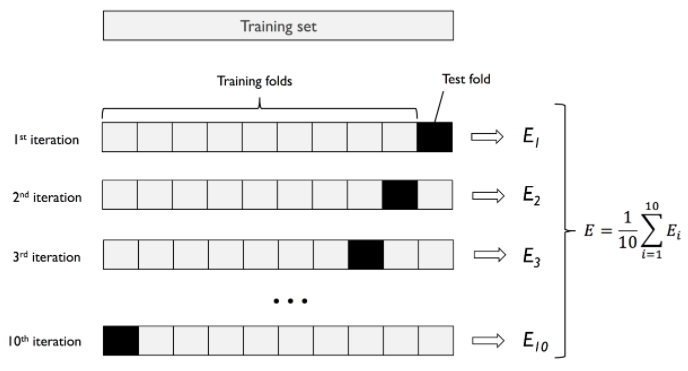

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipe_lr, X = X_train, y = y_train, cv = 10, n_jobs = -1)
print(f'Preciciosnes del modelo CV: {scores}')
print(f'Precision del modelo CV: {np.round(np.mean(scores), 4)} +/- {np.round(np.std(scores), 4)}')

In [ ]:
scores = cross_val_score(estimator = pipe_lr, X = X_test, y = y_test, cv = 10, n_jobs = -1)
print(f'Preciciosnes del modelo CV: {scores}')
print(f'Precision del modelo CV: {np.round(np.mean(scores), 4)} +/- {np.round(np.std(scores), 4)}')

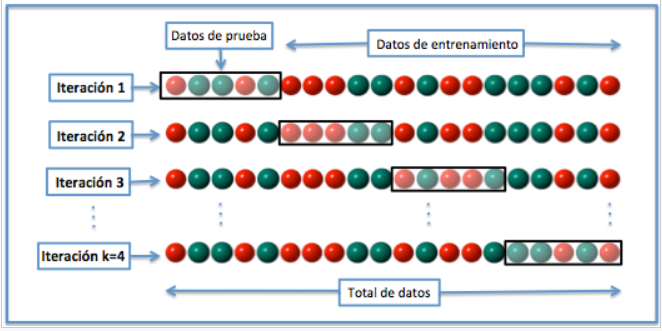

https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada#:~:text=La%20validaci%C3%B3n%20cruzada%20o%20cross,datos%20de%20entrenamiento%20y%20prueba.

## Depurar algoritmos con curvas de validacion y aprendizaje

Las curvas de aprendizaje nos ayudan a evaluar cuando un modelo presenta alta varianza o alto sesgo; recoger mas muestras de entrenamiento podrian ser una solucion a estos problemas, pero es una forma costosa y dificil de ejecutar para resolverlos, y no siempre funciona. Por lo tanto es importante saber tomar una decision correcta acerca de esta alternativa de solucion; resulta que las curvas de aprendizaje tambien nos ayudan a saber cuando el aumento en la cantidad de datos de entrenamiento funciona para nuestros propositos.
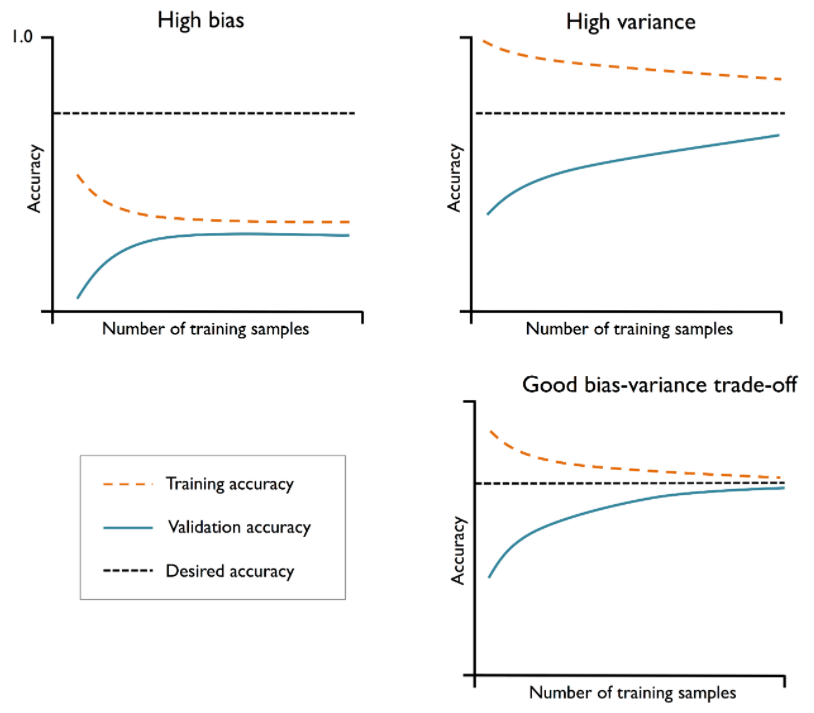

La grafica superior izquierda muestra un alto grado de **subajuste**; esto se puede corregir de varias maneras: 

1. Aumentar el numero de parametros del modelo
2. Recoger o construir caracteristicas adicionales
3. Reducir el grado de regularizacion

La grafica superior derecha presenta **alta varianza**, lo cual se nota por la alta separacion entre la curvas de precision de entrenamiento y de validacion cruzada. Para corregir este problema, tenemos:

1. Recoger mas datos de entrenamiento
2. Reducir la complejidad del modelo
3. Aumentar el parametro de regularizacion

Para los modelo no regularizados tambien puede ser util la reduccion de dimensionalidad, ya se por seleccion de caracteristicas o por extraccion.

Recoger mas datos de entrenamiento puede ayudar a reducir el sobreajuste, pero no siempre, por ejemplo en modelos muy ruidosos o en aquellos que ya esten cerca de su valor optimo. 

* **Curva de prendizaje (Learning Curve):**  Determina puntajes de prueba y entrenamiento con validación cruzada para diferentes tamaños de conjuntos de entrenamiento. 
    
    Un generador de validación cruzada divide todo el conjunto de datos k veces en datos de entrenamiento y prueba. Se utilizarán subconjuntos del conjunto de entrenamiento con diferentes tamaños para entrenar al estimador y se calculará una puntuación para cada tamaño de subconjunto de entrenamiento y el conjunto de prueba. Posteriormente, las puntuaciones se promediarán sobre todas las k carreras para cada tamaño de subconjunto de entrenamiento.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
ax.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
ax.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Number of training samples')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.8, 1.03]);

Se puede ver que el modelo funciona muy bien para muestras de tamaño superior a 250 muestras y que para menos muestras la precision del conjunto de entrenamiento aumenta, mientras que las curvas se separan, indicando esto un aumento del sobreajuste.

## Resolver el sobreajuste y el subajuste con curvas de validacion

Las curvas de validacion son herramientas que permiten aumentar el rendimiento del algoritmo solventando problemas con el subajuste y el sobreajuste.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                param_name='logisticregression__C', param_range=param_range, cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
ax.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

ax.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

ax.grid()
ax.set_xscale('log')
ax.legend(loc='lower right')
ax.set_xlabel('Parameter C')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8, 1.0]);


<div class="burk">
EJERCICIOS</div><i class="fa fa-lightbulb-o "></i>

Vamos a utilizar el archivo `Social_Network_Ads.csv` para practicar un poco de lo visto hasta ahora. El archivo tiene las siguientes columnas

    User ID, Gender, Age, EstimatedSalary, Purchased
    
Buscamos segmentar clientes por algunas de sus caracteristicas y asi evaluar si realizara una cierta compra o no lo hara. La etiqueta de clase estara dada por `Purchased` y las demas columnas seran las columnas de caracterisitcas. Explore el dataset. Ajuste las etiquetas de datos categoricas. Cree un pipeline para escalar y ajustar las caracteristicas a un cierto modelo de clasificacion. Elija el modelo que quiera. Cree una curva de aprendizaje y saque sus conclusiones.

Cree tambien una curva de validacion y elija el parametro a variar. Podria intentar por ejemplo usar el modelo SVC, y crear una curva de validacion para C y lambda. Recuerde que para SVC, C es un parametro que tiene que ver con el ancho del margen: entre mayor sea C mas estrictos somos con el control de los errores, haciendo que C sea menor, y aumentando la posibilidad de sobreajuste. Lambda es un parametro de regularizacion; entre mas grande sea, mas estricto sera el control sobre los pesos, lo que puede llevar a un subajuste.

In [ ]:
social = pd.read_csv('Social_Network_Ads.csv')
social = social.drop(columns = 'User ID')
social.head()

In [ ]:
X = social.iloc[:, :3].values
y = social.iloc[:, -1].values

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
ohe = make_column_transformer((OneHotEncoder(drop = 'first'), [0]), remainder = 'passthrough')
X = ohe.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.decomposition import PCA

parametro = np.linspace(20, 200, 1000)
pipe_rfc = make_pipeline(StandardScaler(), PCA(n_components= 2), SVC())

train_scores, test_scores = validation_curve(estimator = pipe_rfc, X=X_train, y=y_train, 
                                             param_name = 'svc__C',
                                            param_range = parametro, cv = 10, n_jobs=-1)

In [ ]:
pipe_rfc.get_params().keys()

In [ ]:
train_mean = np.mean(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(parametro, train_mean, color = 'b', marker = 'o')
ax.plot(parametro, test_mean, color = 'g', linestyle = '--', marker = 's')
ax.set_xscale('log')

In [ ]:
pipe_rfc = make_pipeline(StandardScaler(), PCA(n_components = 2), SVC(C = 50))
pipe_rfc.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred1 = pipe_rfc.predict(X_train)
y_pred2 = pipe_rfc.predict(X_test)
print(f'Accuracy entrenamiento: {accuracy_score(y_train, y_pred1)}')
print(f'Accuracy prueba: {accuracy_score(y_test, y_pred2)}')

In [ ]:
print(f'Accuracy entrenamiento: {pipe_rfc.score(X_train, y_train)}')
print(f'Accuracy prueba: {pipe_rfc.score(X_test, y_test)}')

In [ ]:
X_train

In [ ]:
# Funcion de graficacion de regiones de decision
# =========================================================
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    print(xx1.shape)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(pipe_rfc.predict(X_train)[0], pipe_rfc.predict(X_train)[1])

## Ajustar los modelos de aprendizaje con busqueda por cuadriculas

La idea de esta tecnica es muy sencilla: se eligen los hiperparametros a optimizar, y los valores que se desean probar; el algoritmo hara una busqueda exhaustiva por fuerxa bruta para encontrar la mejor combinacion de hiperparametros:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC())

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Precision de prueba: {clf.score(X_test, y_test)}')

<div class="burk">
EJERCICIO</div><i class="fa fa-lightbulb-o "></i>

1. Clasifique el dataset del ejercicio anterior usando bosques aleatorios. Optimice los hiperparametros n_estimators y max_depth. Cree una curva de aprendizaje para cada uno, para asi evaluar la posibilidad de sobreajuste y subajuste y realice un grid search. 

## Seleccion de algoritmos con validacion cruzada

En la validacion cruzada anidada tenemos un bucle de validacion cruzada de k iteraciones externo para dividir los datos en iteraciones de prueba y entrenamiento, y un bucle interno para la seleccion del modelo mediante la validacion cruzada de k iteraciones dentro de la iteracion del entrenamiento. Despues de la seleccion del modelo, la iteracion de prueba se utiliza para evaluar el rendimiento del modelo.

En la siguiente imagen se muestra una iteracion cruzada anidada con un 5 iteraciones externas y 2 internas, lo cual puede ser util para conjuntos de datos grandes en donde el coste computacional es importante. Este tipo de configuracion se conoce como **validacion cruzada 5x2**:

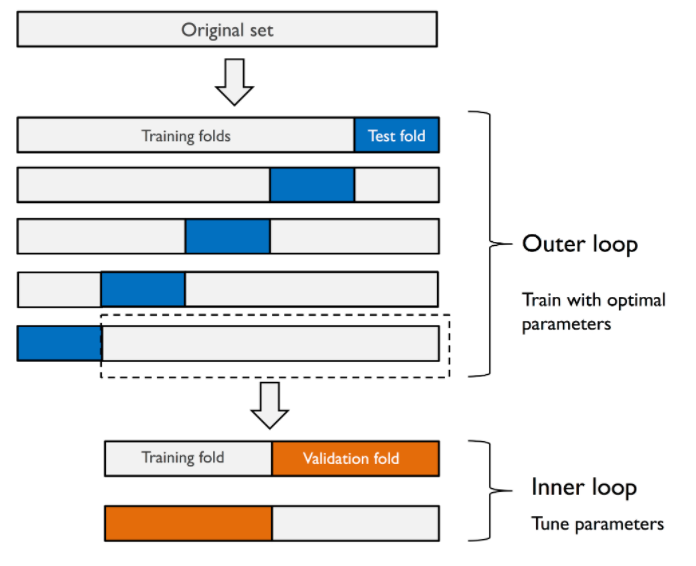

In [ ]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),  np.std(scores)))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

## Diferentes metricas de evaluacion del rendimiento

Hasta ahora hemos estado midiendo el rendimiento de nuestros algoritmos utilizando la precision como medida (accuracy_score); existen otras alternativas que suelen usarse frecuentemente debido a la informacion adicional que presentan, entre ellas, la exactitud, la exhaustividad y el valor F.

 ### Matriz de confusion

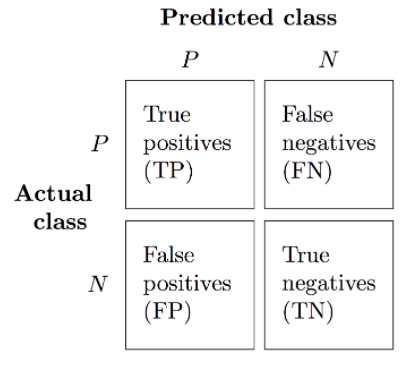

In [ ]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label');

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label');

### Optimizar la exactitud y exhaustividad de un modelo de clasificacion

**Error (ERR):**

$$ERR=\frac{FP+FN}{FP+FN+TP+TN}$$

_________________________________________

**Precision (ACC):**

$$\frac{TP+TN}{FP+FN+TP+TN} = 1 - ERR$$

____________________________________________

Metricas utiles para problemas de clases desbalanceadas:

**Ratio de verdaderos positivos (TPR), Sensibilidad:** 

$$TPR = \frac{TP}{P} = \frac{TP}{FN+TP}$$

_____________________________________________

**Ratio de falsos positivos (FPR), 1 - Especificidad:**

$$FPR = \frac{FP}{N} = \frac{FP}{FP+TN}$$

________________________________________________

**Exactitud (PRE), precision:**

$$PRE=\frac{TP}{TP+FP}$$

___________________________________________

**Exhaustividad (REC), recall:**

$$REC=TPR=\frac{TP}{N} = \frac{TP}{FN+TP}$$

_______________________________________________

**Valor F:**

$$F1=2\frac{PRE \times REC}{PRE + REC}$$


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

In [ ]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

<div class="burk">
EJERCICIO</div><i class="fa fa-lightbulb-o "></i>

Cree una matriz de confusion del ejercicio anterior. Evalue su sensibilidad y su especificidad. Mida el F1 score.

Mas sobre metricas de evaluacion: https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
datos = pd.read_csv('Social_Network_Ads.csv')
datos.head()

In [ ]:
X = datos.iloc[:, 1:4]
y = datos.iloc[:, -1].values

In [ ]:
X = pd.get_dummies(X, drop_first=True).values

In [ ]:
len(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
pipe_svc = make_pipeline(StandardScaler(), SVC()) # C, kernel: rbf, gamma
pipe_svc.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_true = y_test, y_pred = pipe_svc.predict(X_test), labels = [1, 0]) 
# positivo 1:compra; negativo 0:no compra
conf

In [ ]:
# sensibilidad: TP/(TP + FN)
# ====================================
TP = conf[0, 0]
FN = conf[0, 1]
sensibilidad = TP/(TP+FN)
sensibilidad

In [ ]:
# especificidad: TN/(TN + FP)
# ====================================
TN = conf[1, 1]
FP = conf[1, 0]
especificidad = TN/(TN + FP)
especificidad

In [ ]:
from sklearn.model_selection import GridSearchCV
#pipe_svc = make_pipeline(StandardScaler(), SVC()) # C, kernel: rbf, gamma
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator = pipe_svc, param_grid=param_grid, scoring = 'accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
confmat = confusion_matrix(y_test, y_pred, labels = [1, 0])
confmat

In [ ]:
from sklearn.metrics import f1_score
print(f'f1 score: {f1_score(y_test, y_pred)}')

## Caracteristica operativa del receptor (Curva ROC)

Primero es importante aclarar que esta tecnica es util para clasificaciones binarias, tal que se pueda generar una matriz de confusion como la que vimos atras.

Las curvas ROC son utiles para seleccionar modelos basados en su FPR y TPR(Sensibilidad). La diagonal del grafico ROC se interpreta como clasificacion aleatoria, y lo que caiga debajo de la diagonal se considera peor que la clasificacion al azar. 

Su diseño no se basa exactamente en la pertenencia o no a una cierta clase sino a la probabilidad de pertenencia; es muy util para evaluar el rendimiento de modelos de clasificacion binarias, el cual se puede medir con un parametro llamado **ROC AUC**; tambien se utiliza bastante cuando se desean comparar modelos, gracias a la posibilidad de observar los desempeños de forma grafica.

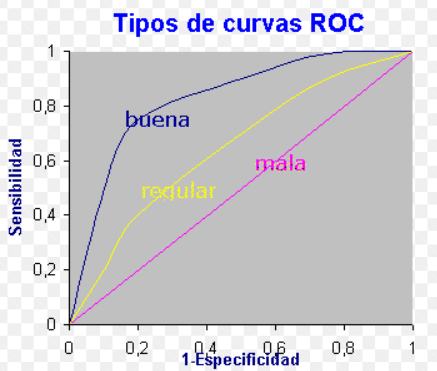

Un clasificador perfecto sera aquel que que caiga en la esquina superior izquierda del grafico con un TPR de 1 y un FPR de 0. Para saber cual modelo es mejor se mira el aura bajo la curva, llamada **ROC AUC**.

Recordemos que `TPR es la proporcion de verdaderos positivos` y `FPR es la proporcion de falsos positivos`. Que la mejor clasificacion se ubique en la esquina superior izquierda implica que  TPR = 1 y FPR = 0. Esto significa que se realiza una clasificacion perfecta de los positivos como positivos (TPR = 1), y que se anula la mala clasificacion de valores negativos como positivos (FPR = 0). Es decir que los verdaderos positivos seran iguales a todos los positivos, sin intrusos no evasores.

In [ ]:
# Procedimiento
# ================================================================
# Creamos y ajustamos nuestro modelo
# ================================================================
pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=2), SVC(probability = True))
pipe_svc.fit(X_train, y_train)

# Ajustamos el mejor hiperparametro C
# =================================================================
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': c_gamma_range},
               {'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

# Obtenemos sus valores en pantalla
# ===========================================================
print(gs.best_score_)
print(gs.best_params_)

# # Ajustamos nuestro modelo al mejor estimador hallado
# ===========================================================
clf = gs.best_estimator_
clf.fit(X_train, y_train)

# Midiendo su rendimiento en los datos de prueba
# ===========================================================
print(f'Precision de prueba: {clf.score(X_test, y_test)}')

In [ ]:
# Creando los parametros de la curva ROC
# ===========================================================
from sklearn.metrics import roc_curve, auc

y_pred = clf.predict_proba(X_test)[:, 0]  # Se manejaran probabilidades de pertenencia a la clase positiva.
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 0) # Calculo de fpr y tpr
auc = auc(fpr, tpr) # Calculo del area bajo la curva

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(fpr, tpr, label = f'ROC: {np.round(auc, 3)}')
ax.set_xlabel('1 - especificidad')
ax.set_ylabel('sensibilidad')
ax.plot([0, 1], [0, 1], linestyle = '--', color = 'k', label = 'Clasificacion aleatoria')
ax.legend()

In [ ]:
# Probando varias muestras 
# ===========================================================
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', C=100))

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
# cv genera una lista de tres tuplas. Cada tupla tiene dos arreglos: indices de X_train e indices de X_test'

fig, ax = plt.subplots(figsize=(8, 6))

for i, (train, test) in enumerate(cv): # 3 ciclos, asociados a los elementos de cv
    pipe_lr.fit(X_train[train], y_train[train])
    probas = pipe_lr.predict_proba(X_train[test]) # Se hace sobre los indices test para validar el entrenamiento
    # Se obtienen las probabilidades de pertenencia a cada clase, sobre el conjunto de test

    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    # Se crea la curva ROC

    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {np.round(roc_auc, 2)})')
    # Se haran 3 graficas, una para cada muestra generada en cv

ax.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Clasificacion aleatoria')

ax.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='perfect performance')

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('1-Especificidad')
ax.set_ylabel('Sensibilidad')
plt.legend(loc="lower right");

<div class="burk">
EJERCICIO
</div><i class="fa fa-lightbulb-o "></i>

1. Utilice la base de datos ubicada 'Sonar.csv'; la ultima columna es la etiqueta de clases (R:roca, M:mina). Explore los datos. Verifique que no haya valores nulos, en caso de haberlos, evalue si es buena idea eliminar sus filas. Separe las matrices X y y. Codifique las columnas (Tenga en cuenta que Cree un pipeline con escalamiento, extraccion de caracteristicas y estimador. Utilice algun clasificador. Cree una curva de validacion para verificar para que valores de los hiperparamteros se produce overfitting. Realice in GridSearch para encontrar los mejores parametros

In [1]:
import pandas as pd
datos = pd.read_csv('sonar.csv', header = None)
datos.head()

0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      51      52      53      54      55      56      57  \
0  0.2111  ...  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084   
1  0.2872  ...  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140  0.0049   
2  0.6194  ...  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316  0.0164   
3  0.1264  ...  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044   
4  0.4459  ...  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048   

       58      59  60  
0  0.0090  0.0032   R  
1  0.0052  0.0044   R  
2  0.0095  0.0078   R  
3  0.0040  0.0117   R  
4  0.0107  0.0094   R  

[5 rows x 61 columns]

In [2]:
X = datos.iloc[:, :60]
y = datos.iloc[:,-1]

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [ ]:
y_train

In [5]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print(f'Rendimiento entrenamiento: {svc.score(X_train, y_train)}')
print(f'Rendimiento Prueba: {svc.score(X_test, y_test)}')

Rendimiento entrenamiento: 0.8855421686746988
Rendimiento Prueba: 0.8333333333333334


In [20]:
from sklearn.model_selection import GridSearchCV
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid = [{'C':param_range, 'kernel': ['linear']},
              {'C':param_range, 'gamma':param_range, 'kernel': ['rbf']}]

gs = GridSearchCV(estimator= svc, param_grid = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9040441176470588
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [21]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [22]:
print(f'Rendimiento entrenamiento: {gs.score(X_train, y_train)}')
print(f'Rendimiento Prueba: {gs.score(X_test, y_test)}')

Rendimiento entrenamiento: 1.0
Rendimiento Prueba: 0.7619047619047619


## Tratar con el desequilibrio de clases

El desequilibrio de clases se presenta cuando hay mucho elementos representativos de una clase frente a pocos de la otra clase. Por ejemplo, para un conjunto de 100 datos, supongamos que 90 pertenencen a la clase 0 y 10 a la clase 1:

    clase 0: 90 datos
    clase 1: 10 datos

Claramente las muestras estan muy desbalanceadas. Ahora supongamos que realizamos una prediccion erronea, prediciendo que todas las 100 muestras pertenecen a la clase 0. Como 90 de ella si pertenecen a la clase 0, entonces tendremos una percision del 90%! Obviamente esto es erroneo pues nuestro algoritmo no hizo nada mas que decir que todas eran de la clase 0, es decir, no aprendio nada. Como tratar con esta situacion?

Primero crearemos una muestra de datos de nuestros datos X y y de la matriz de cancer que hemos venido utilizando, pero procurando que las muestras esten desbalanceadas:

In [ ]:
print(X[y==0].shape)
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))
print(X[y==0].shape[0] + 40)

Se creo un nuevo conjunto de datos con 357 muestras de la clase positiva (0) y 40 de la clase negativa (1). Si alguien dijera que todas las muestras son de la clase positiva, su precision seria de:

$$\frac{357}{397}*100\% = 89.9\%$$

Es una excelente precision, pero en realidad no se esta haciendo nada mas que adivinar por azar, lo cual no implica ningun aprendizaje de maquina.

Adicionalmente, al momento de entrenar algun algoritmos de prediccion, este se vera mas sesgado a favorecer la clase mas abundante pues lo que busca es miniizar el error, basado en una funcion de recompensa.

Una manera de tratar con estos problemas es asignar una penalizacion mayor a las predicciones erroneas en las clases minoritarias. Para ello, es util manejar un parametro llamado `class_weight` a `balanced` (por defecto es None) comun en la mayoria de clasificadores; asignandole dicho valor, el calsificador ajusta los pesos de las clases automaticamente segun la informacion en $y\_train$.

Dado que la anterior tecnica no es perfecta, existen otras alternativas, como por ejemplo el _muestreo ascendente_ , el cual volvera a tomar muestras con reemplazo a partir de los datos actuales, de tal forma que al final se cuente con muestras con la misma cantidad de etiquetas de las clases. 

In [ ]:
from sklearn.utils import resample

print('Numero de muestras de clase uno antes', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1],
                                    replace=True,  n_samples=X_imb[y_imb == 0].shape[0])

print('Numero de muestras de clase uno despues:', X_upsampled.shape[0])

X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

Ahora X_bal y y_bal seran los nuevos conjuntos de entrenamiento, los cuales ya estan balanceados.

Dado que ningun metodo de los anteriores funciona siempre y para todos los casos, sera necesario incluirlos en los ajustes a realizar en una tarea de clasificacion.

Para el conjunto anterior, si nuevamente intentamos la prediccion de que todos son ceros, obtendremos:

In [ ]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100